In [1]:
### Entrenar con todo
import pandas as pd
import numpy as np#metricas de evaluacion
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Train best configuration and model with all data available

In [2]:
df_sets = pd.read_csv("../Datos/koi_sets_unb.csv") 
df_labels = pd.read_csv("../Datos/koi_metadata_p_error.csv")
df_labels.drop(["Transit Number"],axis=1,inplace=True)


lc_all = np.load("../../Processed_Data/koi_light_curves_full.npy")
#lc_total = np.load("../../Processed_Data/koi_light_curves_model_full.npy")

mask_total = (df_sets["Set"] != "Unlabeled").values
mask_test = (df_sets["Set"] == "Unlabeled").values

df_labels_total = df_labels[mask_total] #labeled data
df_labels_test = df_labels[mask_test]
lc_total = lc_all[mask_total] 
lc_test = lc_all[mask_test]

y_total = ((df_labels_total["NExScI Disposition"]=="CONFIRMED")*1).values
print(y_total.shape)

(6257,)


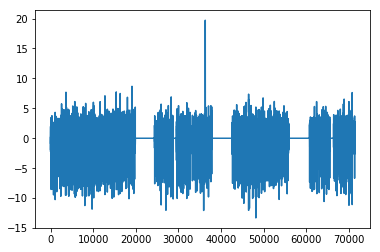

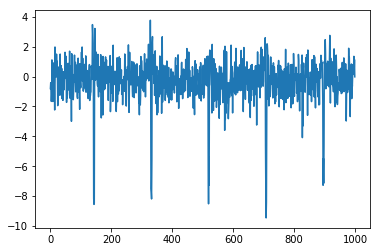

In [3]:
plt.plot(lc_all[787]) #new confirmed
plt.show()

plt.plot(lc_all[787][:1000]) #new confirmed
plt.show()

In [ ]:
#need to drop "transit number"

Text(0,0.5,'Count')

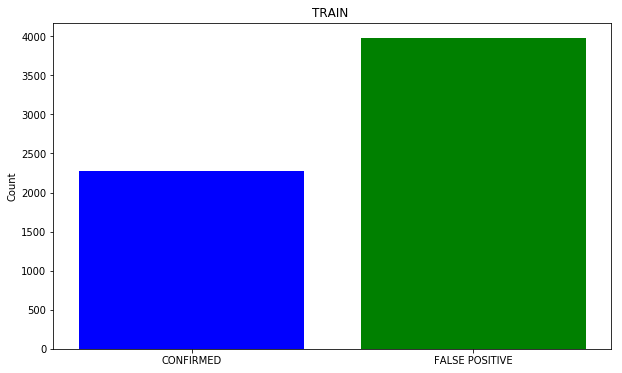

In [52]:
plt.figure(figsize=(10,6))
plt.title("TRAIN ")
plt.bar(0, np.sum(y_train=="CONFIRMED"),color="blue")
plt.bar(1, np.sum(y_train=="FALSE POSITIVE"),color="green")
plt.xticks([0,1],["CONFIRMED","FALSE POSITIVE"])
plt.ylabel("Count")

In [53]:
from collections import Counter 

Counter(mask_t)

Counter({False: 3362, True: 4692})

### Extract representation -- Selected: OwnFATS

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

from scipy import stats
from scipy.signal import resample
from sklearn.linear_model import LinearRegression

def amplitude(magnitudes):
    return 0.5 * (np.max(magnitudes) - np.min(magnitudes))

def median_absolute_deviation(magnitudes):
    median = np.median(magnitudes)
    deviations = magnitudes - median
    absolute_deviations = np.absolute(deviations)
    return np.median(absolute_deviations)

def residual_bright_faint_ratio(magnitudes):    # median as a fit
    mean = np.mean(magnitudes)
    brighter = magnitudes[magnitudes >= mean]
    fainter = magnitudes[magnitudes <= mean]

    resid_brighter = np.mean(np.square(brighter - mean))
    resid_fainter = np.mean(np.square(fainter - mean))

    ratio = resid_fainter / (resid_brighter+1e-14)
    return ratio

def own_fats(sequence):
    time_ex =  np.arange(len(sequence))

    minim=np.min(sequence)
    maxim = np.max(sequence)
    mean = np.mean(sequence)
    std = np.std(sequence)
    iqr = stats.iqr(sequence) #q31
    skew = stats.skew(sequence)
    kurt = stats.kurtosis(sequence)
    q1 = np.percentile(sequence, 25)
    q2 = np.percentile(sequence, 50)
    model = LinearRegression(normalize=True,n_jobs=-1)
    model.fit(time_ex.reshape(-1,1),sequence)
    slope = model.coef_[0]
    #new features
    ampl = amplitude(sequence)
    mad = median_absolute_deviation(sequence)
    br_fa = residual_bright_faint_ratio(sequence)
    median = np.median(sequence)
    return np.array([minim,maxim,mean,std,iqr,skew,kurt,q1,q2,slope,ampl,mad,br_fa,median])

columns_FATS = ["Minimum","Maximum","Mean","Std","IQR","Skew","Kurtosis","Q1","Q2","Slope","Amplitude","MAD",
               "Residual Bright Faint Ratio","Median"]

X_total_fats = []
for sequence in lc_total:
    aux = own_fats(sequence)
    X_total_fats.append(aux)
X_total_fats =  np.asarray(X_total_fats)

X_test_fats = []
for sequence in lc_test:
    aux = own_fats(sequence)
    X_test_fats.append(aux)
X_test_fats =  np.asarray(X_test_fats)

print("Train shape FATS: ",X_total_fats.shape)
print("Test shape FATS: ",X_test_fats.shape)

Train shape FATS:  (6257, 14)
Test shape FATS:  (1797, 14)


In [5]:
aux = df_labels_total.iloc[:,3:]
aux.fillna(aux.median(), inplace=True)
X_total_class = np.concatenate([aux , X_total_fats],axis=1)
aux = df_labels_test.iloc[:,3:]
aux.fillna(aux.median(), inplace=True)
X_test_class = np.concatenate([aux , X_test_fats] ,axis=1)
print("Train shape FATS: ",X_total_class.shape)
print("Test shape FATS: ",X_test_class.shape)

Train shape FATS:  (6257, 71)
Test shape FATS:  (1797, 71)


In [6]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
Xstd_train = std.fit_transform(X_total_class.astype('float'))
Xstd_test = std.transform(X_test_class)

In [7]:
###MODEL 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, accuracy_score, precision_score

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score_we':make_scorer(f1_score,average='weighted'),
    'f1_score_macro':make_scorer(f1_score,average='macro'),
    'f1_score_micro':make_scorer(f1_score,average='micro')
}

clf = RandomForestClassifier(n_jobs=-1, random_state=0)

param_grid = {
    'n_estimators' : [10,20,30,40,50,60,70,80,90,100],
    'min_samples_split': [5,10,15,20,25],
    'class_weight' : ['balanced','balanced_subsample',None]
}

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit='f1_score_we',
                       cv=skf, return_train_score=False, n_jobs=-1)
grid_search.fit(Xstd_train, y_total)

print('Best params for completeness:', grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
bestResults = results[results.params == grid_search.best_params_]
completeness = float(bestResults['mean_test_recall_score'])
print('Completion: {:.4f}'.format(completeness))
preci = float(bestResults['mean_test_precision_score'])
print('Contamination: {:.4f}'.format(preci))
f1_w = float(bestResults['mean_test_f1_score_we'])
print('F1-score weighted: {:.4f}'.format(f1_w))
f1_ma = float(bestResults['mean_test_f1_score_macro'])
print('F1-score macro: {:.4f}'.format(f1_ma))
f1_mi = float(bestResults['mean_test_f1_score_micro'])
print('F1-score micro: {:.4f}'.format(f1_mi))

aux = grid_search.best_params_

Best params for completeness: {'class_weight': 'balanced_subsample', 'min_samples_split': 15, 'n_estimators': 60}
Completion: 0.9132
Contamination: 0.9244
F1-score weighted: 0.9409
F1-score macro: 0.9362
F1-score micro: 0.9410


In [161]:
#parametros escojidos anteriormente..
aux = {'class_weight': None, 'min_samples_split': 5, 'n_estimators': 90}

#found in this data...
#Best params for completeness: {'class_weight': 'balanced_subsample', 'min_samples_split': 15, 'n_estimators': 60}

In [8]:
from sklearn.ensemble import RandomForestClassifier

#modelo final 
feat_imp = []
pred_prom = []
#for i in range(10):   #con 10 o 5
model = RandomForestClassifier(random_state=0, n_jobs=-1,**aux) #necesario random state
model.fit(Xstd_train,y_total) 

pred=model.predict(Xstd_test) 
#pred_prom.append(pred)
#feat_imp.append(model.feature_importances_)
pred_prom = pred
feat_imp = model.feature_importances_

#feat_imp = np.mean(feat_imp,axis=0)
#pred_prom = np.mean(pred_prom,axis=0)>0.5

In [9]:
print("Cantidad de Confirmados ",np.sum(pred_prom))
print("Cantidad de Falsos positivos  ",np.sum(pred_prom==0))

Cantidad de Confirmados  755
Cantidad de Falsos positivos   1042


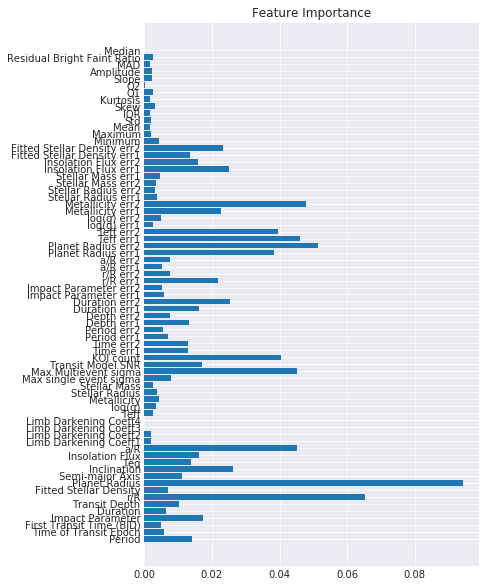

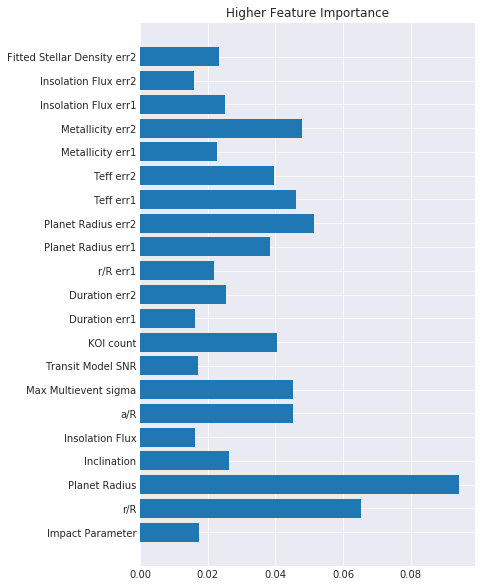

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(6,10))
columns_names = np.asarray(list(df_labels_total.columns[3:])+columns_FATS)

plt.barh(range(len(columns_names)), feat_imp)
plt.yticks(range(len(columns_names)),columns_names)#, rotation= 30)
plt.title('Feature Importance')
plt.show()

k = 20
most_relevant = feat_imp >= np.sort(feat_imp)[::-1][k] #mask
plt.figure(figsize=(6,10))
plt.barh(range(len(columns_names[most_relevant])), feat_imp[most_relevant])
plt.yticks(range(len(columns_names[most_relevant])),columns_names[most_relevant])#, rotation= 30)
plt.title('Higher Feature Importance')
plt.show()

In [13]:
df_results = pd.DataFrame()
df_results["KOI Name"] = df_labels_test["KOI Name"]   ###esto va con TEST
final=[]
for pred in pred_prom:
    if pred==False:
        final.append("FALSE POSITIVE")
    else: 
        final.append("CONFIRMED")
df_results["Our Disposition"] = final####model.predict(X)
#df_resullts["Planets Count"] = 
print(df_results.shape)
df_results.head()

(1797, 2)


,KOI Name,Our Disposition
4,K00958.01,CONFIRMED
5,K00984.01,CONFIRMED
8,K00994.01,CONFIRMED
11,K00992.02,CONFIRMED
18,K04359.01,FALSE POSITIVE


In [14]:
df_kepler = pd.read_csv("../Datos/kepler_dataset.csv") #all kepler data
df_results = df_results.merge(df_kepler,on="KOI Name")
#df_results.drop("Kepler Name") #deberia ser nan
df_results.dropna(axis=1,how='all').shape
df_results

,KOI Name,Our Disposition,Kepler ID,Kepler Name,KOI Number,Kepler Disposition,NExScI Disposition,RA (J2000),RA Error,Dec (J2000),...,Contamination Flag,Insolation Flux,Insolation Flux err1,Insolation Flux err2,Fitted Stellar Density,Fitted Stellar Density err1,Fitted Stellar Density err2,Planetary Fit,Disposition Score,File Name
0,K00958.01,CONFIRMED,1026957,NaN,958.01,CANDIDATE,CANDIDATE,19 25 01.078,0.0,+36 44 37.00,...,0,13.18,3.00,-1.98,102.86534,5.47239,-30.25813,LS+MCMC,1.000,kplr001026957-20160128150956_dvt.fits
1,K00984.01,CONFIRMED,1161345,NaN,984.01,CANDIDATE,CANDIDATE,19 24 11.712,0.0,+36 50 23.58,...,0,186.31,56.73,-28.39,8.16471,4.69586,-1.63188,LS+MCMC,0.711,kplr001161345-20160128150956_dvt.fits
2,K00994.01,CONFIRMED,1431122,NaN,994.01,CANDIDATE,CANDIDATE,19 24 34.198,0.0,+37 03 40.76,...,0,283.62,100.01,-78.24,0.05666,3.20152,-0.06620,LS+MCMC,0.990,kplr001431122-20160128150956_dvt.fits
3,K00992.02,CONFIRMED,1432789,NaN,992.02,CANDIDATE,CANDIDATE,19 25 59.861,0.0,+37 03 33.41,...,0,499.41,210.40,-153.04,0.58469,0.04511,-0.31824,LS+MCMC,0.961,kplr001432789-20160128150956_dvt.fits
4,K04359.01,FALSE POSITIVE,1575873,NaN,4359.01,CANDIDATE,CANDIDATE,19 27 42.326,0.0,+37 06 04.65,...,0,30567.67,18880.37,-17052.93,2.25862,15.02837,-1.46534,LS+MCMC,1.000,kplr001575873-20160128150956_dvt.fits
5,K03145.01,CONFIRMED,1717722,NaN,3145.01,CANDIDATE,CANDIDATE,19 22 28.315,0.0,+37 17 20.72,...,0,95.61,38.11,-21.67,2.61043,4.63396,-2.21540,LS+MCMC,1.000,kplr001717722-20160128150956_dvt.fits
6,K03145.02,FALSE POSITIVE,1717722,NaN,3145.02,CANDIDATE,CANDIDATE,19 22 28.315,0.0,+37 17 20.72,...,0,737.36,293.96,-167.10,3.17024,0.35594,-1.81104,LS+MCMC,0.858,kplr001717722-20160128150956_dvt.fits
7,K04053.01,CONFIRMED,1718958,NaN,4053.01,CANDIDATE,CANDIDATE,19 23 40.642,0.0,+37 17 13.81,...,0,1968.38,836.24,-503.00,1.95904,1.98658,-1.91843,LS+MCMC,0.985,kplr001718958-20160128150956_dvt.fits
8,K04644.01,FALSE POSITIVE,1721157,NaN,4644.01,CANDIDATE,CANDIDATE,19 25 49.762,0.0,+37 12 24.63,...,0,206.55,91.39,-46.68,6.48403,5.43333,-3.39902,LS+MCMC,0.970,kplr001721157-20160128150956_dvt.fits
9,K07624.01,FALSE POSITIVE,1723078,NaN,7624.01,CANDIDATE,CANDIDATE,19 27 28.322,0.0,+37 16 11.56,...,0,12.36,5.55,-8.42,4.04249,14.39050,-3.71379,LS+MCMC,0.246,kplr001723078-20160128150956_dvt.fits


In [55]:
df_results["Comments"]

0                                            CENT_KIC_POS
1                                              NO_COMMENT
2                                            CENT_KIC_POS
3                                              NO_COMMENT
4                                          CENT_SATURATED
5                                           CENT_FEW_MEAS
6                                            CENT_KIC_POS
7                                              NO_COMMENT
8                                              NO_COMMENT
9                                              NO_COMMENT
10                                             NO_COMMENT
11                                             NO_COMMENT
12                                         CENT_UNCERTAIN
13                                             NO_COMMENT
14                                             NO_COMMENT
15                                         CENT_FEW_DIFFS
16                                             NO_COMMENT
17            

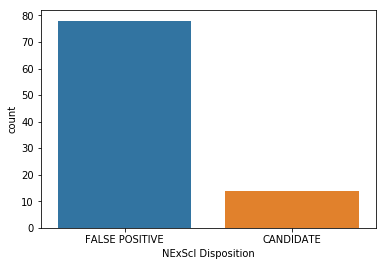

In [67]:
sns.countplot(data=df_kepler[df_kepler["Planetary Fit"]=="LS"],x="NExScI Disposition")
plt.show()
sns.countplot(data=df_kepler,x="Planetary Fit")
plt.show()

In [15]:
#save!
df_results.to_csv("koi_disposition_2019.csv",index=False)

In [2]:
#load!
df_results = pd.read_csv("koi_disposition_2019.csv")
df_results.head()

,KOI Name,Our Disposition,Kepler ID,Kepler Name,KOI Number,Kepler Disposition,NExScI Disposition,RA (J2000),RA Error,Dec (J2000),...,Contamination Flag,Insolation Flux,Insolation Flux err1,Insolation Flux err2,Fitted Stellar Density,Fitted Stellar Density err1,Fitted Stellar Density err2,Planetary Fit,Disposition Score,File Name
0,K00958.01,CONFIRMED,1026957,NaN,958.01,CANDIDATE,CANDIDATE,19 25 01.078,0.0,+36 44 37.00,...,0,13.18,3.00,-1.98,102.86534,5.47239,-30.25813,LS+MCMC,1.000,kplr001026957-20160128150956_dvt.fits
1,K00984.01,CONFIRMED,1161345,NaN,984.01,CANDIDATE,CANDIDATE,19 24 11.712,0.0,+36 50 23.58,...,0,186.31,56.73,-28.39,8.16471,4.69586,-1.63188,LS+MCMC,0.711,kplr001161345-20160128150956_dvt.fits
2,K00994.01,CONFIRMED,1431122,NaN,994.01,CANDIDATE,CANDIDATE,19 24 34.198,0.0,+37 03 40.76,...,0,283.62,100.01,-78.24,0.05666,3.20152,-0.06620,LS+MCMC,0.990,kplr001431122-20160128150956_dvt.fits
3,K00992.02,CONFIRMED,1432789,NaN,992.02,CANDIDATE,CANDIDATE,19 25 59.861,0.0,+37 03 33.41,...,0,499.41,210.40,-153.04,0.58469,0.04511,-0.31824,LS+MCMC,0.961,kplr001432789-20160128150956_dvt.fits
4,K04359.01,FALSE POSITIVE,1575873,NaN,4359.01,CANDIDATE,CANDIDATE,19 27 42.326,0.0,+37 06 04.65,...,0,30567.67,18880.37,-17052.93,2.25862,15.02837,-1.46534,LS+MCMC,1.000,kplr001575873-20160128150956_dvt.fits


In [17]:
df_results[df_results["KOI Number"] == 4.01] #this should be confirmed!

,KOI Name,Our Disposition,Kepler ID,Kepler Name,KOI Number,Kepler Disposition,NExScI Disposition,RA (J2000),RA Error,Dec (J2000),...,Contamination Flag,Insolation Flux,Insolation Flux err1,Insolation Flux err2,Fitted Stellar Density,Fitted Stellar Density err1,Fitted Stellar Density err2,Planetary Fit,Disposition Score,File Name
169,K00004.01,FALSE POSITIVE,3861595,NaN,4.01,CANDIDATE,CANDIDATE,19 37 25.570,0.0,+38 56 50.57,...,0,4055.29,1643.78,-2336.51,0.22463,0.17327,-0.08789,LS+MCMC,1.0,kplr003861595-20160128150956_dvt.fits


In [5]:
df_results.fillna(df_results.median(),inplace=True)
mask_con = df_results["Our Disposition"] == "CONFIRMED"
mask_fp = df_results["Our Disposition"] == "FALSE POSITIVE"

/users/fmena/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


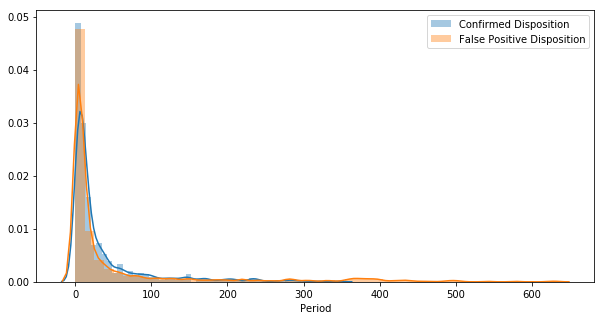

In [17]:
plt.figure(figsize=(10,5))
sns.distplot(df_results["Period"][mask_con],label="Confirmed Disposition",kde=True)
sns.distplot(df_results["Period"][mask_fp].values,label="False Positive Disposition",kde=True)
plt.legend()
plt.show()

/users/fmena/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


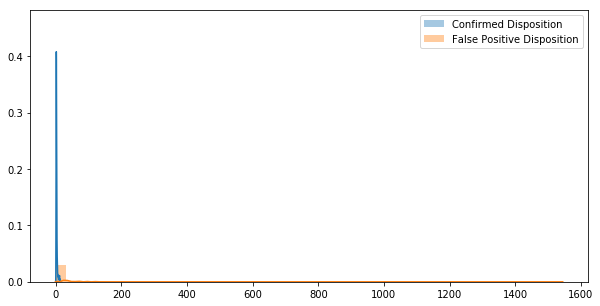

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(df_results["Planet Radius"][mask_con].values,label="Confirmed Disposition",kde=True,norm_hist=True)
sns.distplot(df_results["Planet Radius"][mask_fp].values,label="False Positive Disposition",kde=True,norm_hist=True)
plt.legend()
plt.show()

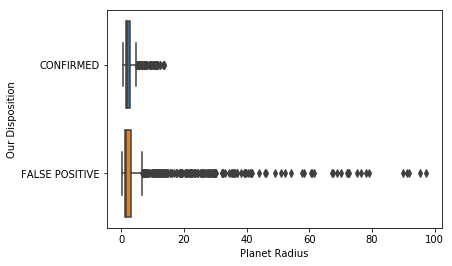

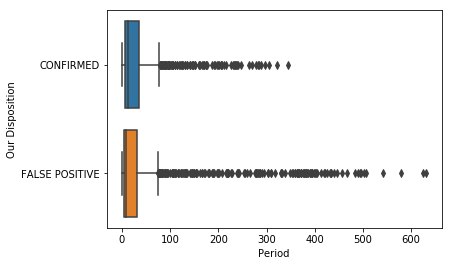

In [21]:
sns.boxplot(x="Planet Radius",y="Our Disposition",data=df_results[df_results["Planet Radius"]<100])
plt.show()
sns.boxplot(x="Period",y="Our Disposition",data=df_results)
plt.show()

In [16]:
df_results["Planet Radius"][mask_con].describe()

count    755.000000
mean       2.470821
std        2.027555
min        0.440000
25%        1.350000
50%        1.940000
75%        2.745000
max       13.600000
Name: Planet Radius, dtype: float64

In [17]:
df_results["Planet Radius"][mask_fp].describe()

count    1042.000000
mean        9.415345
std        53.021449
min         0.220000
25%         1.090000
50%         1.580000
75%         3.330000
max      1543.740000
Name: Planet Radius, dtype: float64

In [6]:
#check data of confirmed
columns_to_insp = ["KOI Name","Planet Radius","Teq","Inclination","r/R","Period","Transit Depth","Duration","Semi-major Axis",
                  "Stellar Mass","Stellar Radius","Metallicity","Teff"]
conf_planets = df_results[mask_con][columns_to_insp]
conf_planets.describe()

,Planet Radius,Teq,Inclination,r/R,Period,Transit Depth,Duration,Semi-major Axis,Stellar Mass,Stellar Radius,Metallicity,Teff
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,2.470821,796.192053,87.992464,0.022127,34.522003,837.268609,4.238155,0.170393,0.954780,1.088107,0.009709,5523.295364
std,2.027555,343.113562,3.019699,0.018013,54.799504,2299.039511,2.935582,0.174141,0.210305,0.441760,0.214447,655.182793
min,0.440000,176.000000,63.990000,0.004000,0.524176,18.500000,0.513400,0.010000,0.236000,0.250000,-1.460000,3421.000000
25%,1.350000,535.500000,87.535000,0.012000,5.828714,150.800000,2.240050,0.061000,0.831000,0.829000,-0.120000,5227.000000
50%,1.940000,771.000000,89.030000,0.018000,12.671437,344.400000,3.434000,0.104000,0.955000,0.986000,0.040000,5640.000000
75%,2.745000,997.500000,89.760000,0.026000,34.604077,669.000000,5.382000,0.207000,1.054500,1.235500,0.160000,5949.500000
max,13.600000,2149.000000,90.000000,0.170000,345.158935,34513.700000,24.708000,0.975000,2.018000,4.240000,0.560000,7732.000000


In [58]:
#http://www.as.utexas.edu/astronomy/education/sum11/endl/secure/AST_s309_ss11_6.pdf
#missing Teq and Teff -- "Transit Depth": 0.0084--"Inclination":1.65..
earth = {"Planet Radius":1, "Period":1*365, "Duration":13.0,"Semi-major Axis": 1,"Teq":260} #let transit?
jupyter = {"Planet Radius":11.209, "Period":11.86*365, "Duration":29.6,"Semi-major Axis": 5.2,"Teq":130}
sun = {"Stellar Mass": 1, "Stellar Radius": 1, "Metallicity": 0, "Teff":5777}
earth_sun = dict(list(earth.items()) + list(sun.items()) + [("r/R", 1/1)])
jupyter_sun = dict(list(jupyter.items()) + list(sun.items()) + [("r/R", 11.209/1)])
earth_sun

{'Planet Radius': 1,
 'Period': 365,
 'Duration': 13.0,
 'Semi-major Axis': 1,
 'Teq': 260,
 'Stellar Mass': 1,
 'Stellar Radius': 1,
 'Metallicity': 0,
 'Teff': 5777,
 'r/R': 1.0}

In [57]:
#similar to earth
vec_sim = conf_planets[list(earth.keys())]

sim = np.sum( np.square(vec_sim.values - list(earth.values()) ) ,axis=1) #maybe normalize distance?
print(earth)
conf_planets.iloc[np.argsort(sim)].head()

{'Planet Radius': 1, 'Period': 365, 'Duration': 13.0, 'Semi-major Axis': 1, 'Teq': 260}


,KOI Name,Planet Radius,Teq,Inclination,r/R,Period,Transit Depth,Duration,Semi-major Axis,Stellar Mass,Stellar Radius,Metallicity,Teff
1591,K01431.01,7.79,241.0,89.77,0.077,345.158935,5087.9,7.5646,0.975,1.032,0.931,0.28,5597.0
1239,K01411.01,7.82,284.0,89.87,0.062,305.076247,4042.8,6.2550,0.912,1.083,1.155,0.40,5716.0
668,K01375.01,7.25,310.0,89.86,0.052,321.212437,2358.6,4.0120,0.945,1.090,1.286,0.06,6018.0
1078,K05552.01,2.10,265.0,90.00,0.019,295.958914,464.1,4.2440,0.831,0.871,0.992,0.00,5505.0
1118,K03801.01,13.21,300.0,89.92,0.099,288.312867,11181.0,5.4190,0.846,0.969,1.220,0.10,5672.0


In [51]:
#similar to jupyter
vec_sim = conf_planets[list(jupyter.keys())]

sim = np.sum( np.square(vec_sim.values - list(jupyter.values()) ) ,axis=1) #maybe normalize distance?
print(jupyter)
conf_planets.iloc[np.argsort(sim)].head()

{'Planet Radius': 11.209, 'Period': 4328.9, 'Duration': 29.6, 'Semi-major Axis': 5.2}


,KOI Name,Planet Radius,Teq,Inclination,r/R,Period,Transit Depth,Duration,Semi-major Axis,Stellar Mass,Stellar Radius,Metallicity,Teff
1591,K01431.01,7.79,241.0,89.77,0.077,345.158935,5087.9,7.5646,0.975,1.032,0.931,0.28,5597.0
668,K01375.01,7.25,310.0,89.86,0.052,321.212437,2358.6,4.0120,0.945,1.090,1.286,0.06,6018.0
1239,K01411.01,7.82,284.0,89.87,0.062,305.076247,4042.8,6.2550,0.912,1.083,1.155,0.40,5716.0
1078,K05552.01,2.10,265.0,90.00,0.019,295.958914,464.1,4.2440,0.831,0.871,0.992,0.00,5505.0
1118,K03801.01,13.21,300.0,89.92,0.099,288.312867,11181.0,5.4190,0.846,0.969,1.220,0.10,5672.0


In [59]:
#planets with star similar to sun
vec_sim = conf_planets[list(sun.keys())]

sim = np.sum( np.square(vec_sim.values - list(sun.values()) ) ,axis=1) #maybe normalize distance?
print(sun)
conf_planets.iloc[np.argsort(sim)].head()

{'Stellar Mass': 1, 'Stellar Radius': 1, 'Metallicity': 0, 'Teff': 5777}


,KOI Name,Planet Radius,Teq,Inclination,r/R,Period,Transit Depth,Duration,Semi-major Axis,Stellar Mass,Stellar Radius,Metallicity,Teff
48,K02489.01,1.82,1074.0,89.22,0.020,3.924530,463.5,3.6910,0.048,0.939,0.849,-0.18,5776.0
427,K03341.01,2.13,700.0,87.30,0.014,27.096515,208.4,8.4200,0.179,1.038,1.352,0.14,5775.0
428,K03341.02,1.48,930.0,87.56,0.010,11.547498,115.5,6.6840,0.101,1.038,1.352,0.14,5775.0
1213,K01398.01,3.00,955.0,85.35,0.032,5.823489,888.7,2.2441,0.061,0.916,0.864,-0.22,5774.0
1548,K01946.01,2.76,876.0,84.66,0.027,8.294828,559.5,2.7437,0.079,0.967,0.939,-0.04,5773.0


In [60]:
#planets most similar to earth, and same star/sun
vec_sim = conf_planets[list(earth_sun.keys())]

sim = np.sum( np.square(vec_sim.values - list(earth_sun.values()) ) ,axis=1) #maybe normalize distance?
print(earth_sun)
conf_planets.iloc[np.argsort(sim)].head()

{'Planet Radius': 1, 'Period': 365, 'Duration': 13.0, 'Semi-major Axis': 1, 'Teq': 260, 'Stellar Mass': 1, 'Stellar Radius': 1, 'Metallicity': 0, 'Teff': 5777, 'r/R': 1.0}


,KOI Name,Planet Radius,Teq,Inclination,r/R,Period,Transit Depth,Duration,Semi-major Axis,Stellar Mass,Stellar Radius,Metallicity,Teff
1239,K01411.01,7.82,284.0,89.87,0.062,305.076247,4042.8,6.2550,0.912,1.083,1.155,0.40,5716.0
813,K00683.01,5.86,286.0,89.84,0.051,278.124398,2297.8,3.9780,0.842,1.028,1.050,0.14,5799.0
1395,K01783.02,6.36,321.0,89.65,0.044,284.063137,1628.1,8.2970,0.845,0.996,1.336,0.02,5791.0
1114,K01268.01,13.57,321.0,89.85,0.095,268.941097,9010.2,5.4434,0.827,1.041,1.306,0.14,5798.0
1118,K03801.01,13.21,300.0,89.92,0.099,288.312867,11181.0,5.4190,0.846,0.969,1.220,0.10,5672.0
